In [15]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft as fft
import numpy as np
import IPython.display as ipd
import import_ipynb

import helper_functions
import matplotlib as mpl

In [16]:
file_path = "sounds/cepstrum_test.wav"
np.random.seed(297)

In [17]:
fs, signal = wavfile.read(file_path)
print(f"signal: {signal}")
print(f"signal shape: {signal.shape}")
mono_signal = signal[:, 0]

signal: [[  0   0]
 [ -1  -1]
 [  2   2]
 ...
 [-78  -4]
 [-64  25]
 [-56  30]]
signal shape: (216781, 2)


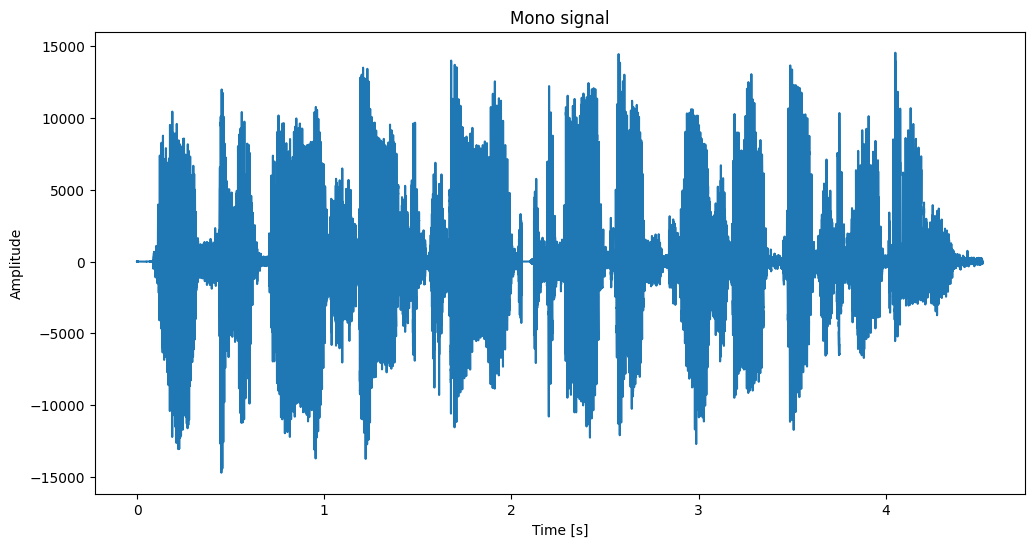

In [18]:
window_length_ms = 40
window_length = int(window_length_ms * fs / 1000)


spectrum_length = 5000

windowing_fn = np.sin(np.pi * np.arange(0.5, window_length, 1)/window_length)**2
total_length = len(mono_signal)

t = np.arange(0, total_length)/fs
plt.figure(figsize=(12, 6))
plt.plot(t, mono_signal)
plt.title("Mono signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

ipd.display(ipd.Audio(file_path))

## LOG-SPECTRUM AND CEPSTRUM

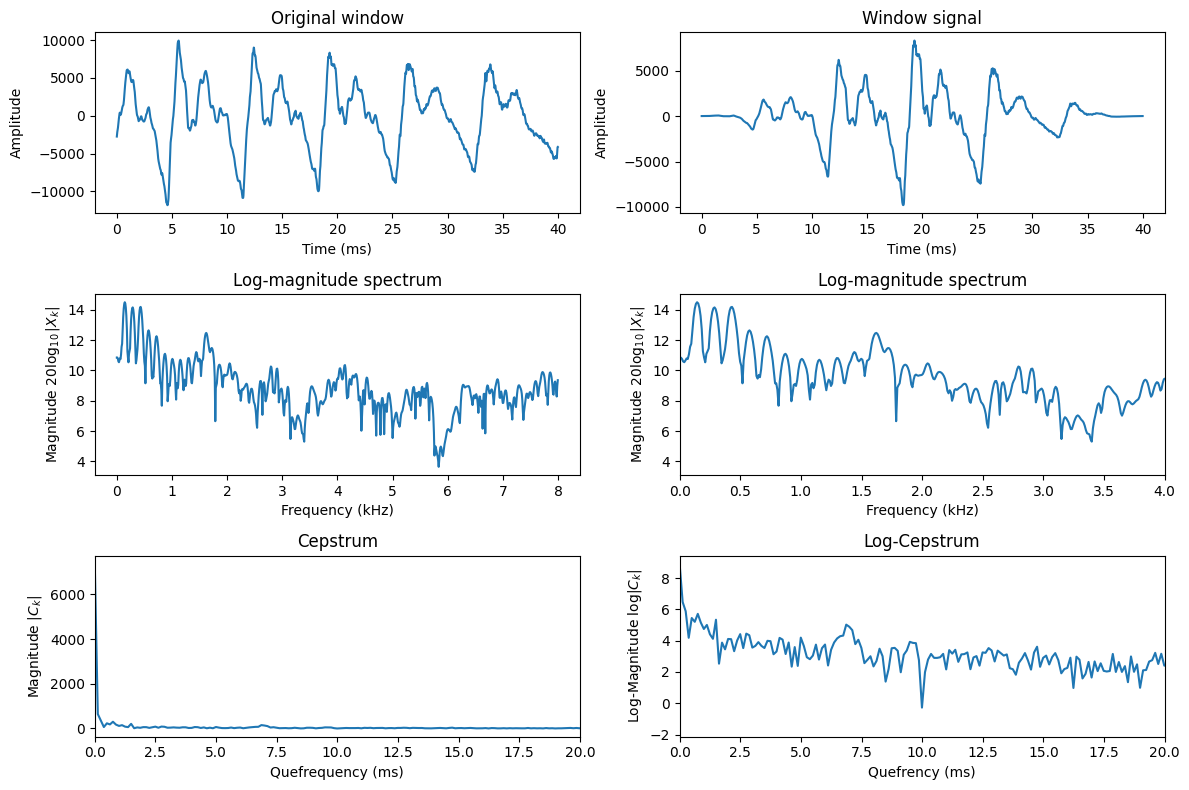

In [19]:
# Choose segment from random position in sample
starting_position = np.random.randint(total_length - window_length)

data_vector = mono_signal[starting_position:(starting_position+window_length),]
window = data_vector * windowing_fn
time_vector = np.linspace(0, window_length_ms, window_length)

spectrum = fft.rfft(window, n=spectrum_length)
frequency_vector = np.linspace(0, fs/2000, len(spectrum))

# downsample to 16kHz (that is, Nyquist frequency is 8 kHz, that is everything about 8kHz can be removed)
idx = np.nonzero(frequency_vector <= 8)
frequency_vector = frequency_vector[idx]
spectrum = spectrum[idx]

log_spectrum = np.log(np.abs(spectrum))
cepstrum = fft.rfft(log_spectrum)

ctime = np.linspace(0, 0.5*1000*spectrum_length/fs, len(cepstrum))

plt.figure(figsize=[12, 8])
plt.subplot(321)
plt.plot(time_vector, data_vector)
plt.title("Original window")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(322)
plt.plot(time_vector, window)
plt.title("Window signal")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(323)
plt.plot(frequency_vector, log_spectrum)
plt.title("Log-magnitude spectrum")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude $20\\log_{10}|X_k|$")

plt.subplot(324)
plt.plot(frequency_vector, log_spectrum)
plt.title("Log-magnitude spectrum")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude $20\\log_{10}|X_k|$")
ax = plt.axis()
ax = [0, 4, ax[2], ax[3]]
plt.axis(ax)

plt.subplot(325)
plt.plot(ctime, np.abs(cepstrum))
plt.title("Cepstrum")
plt.xlabel("Quefrequency (ms)")
plt.ylabel("Magnitude $|C_k|$")
ax = plt.axis()
ax = [0, 20, ax[2], ax[3]]
plt.axis(ax)

plt.subplot(326)
plt.plot(ctime, np.log(np.abs(cepstrum)))
plt.title("Log-Cepstrum")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Log-Magnitude $\\log|C_k|$")
ax = plt.axis()
ax = [0, 20, ax[2], ax[3]]
plt.axis(ax)
plt.tight_layout()
plt.show()

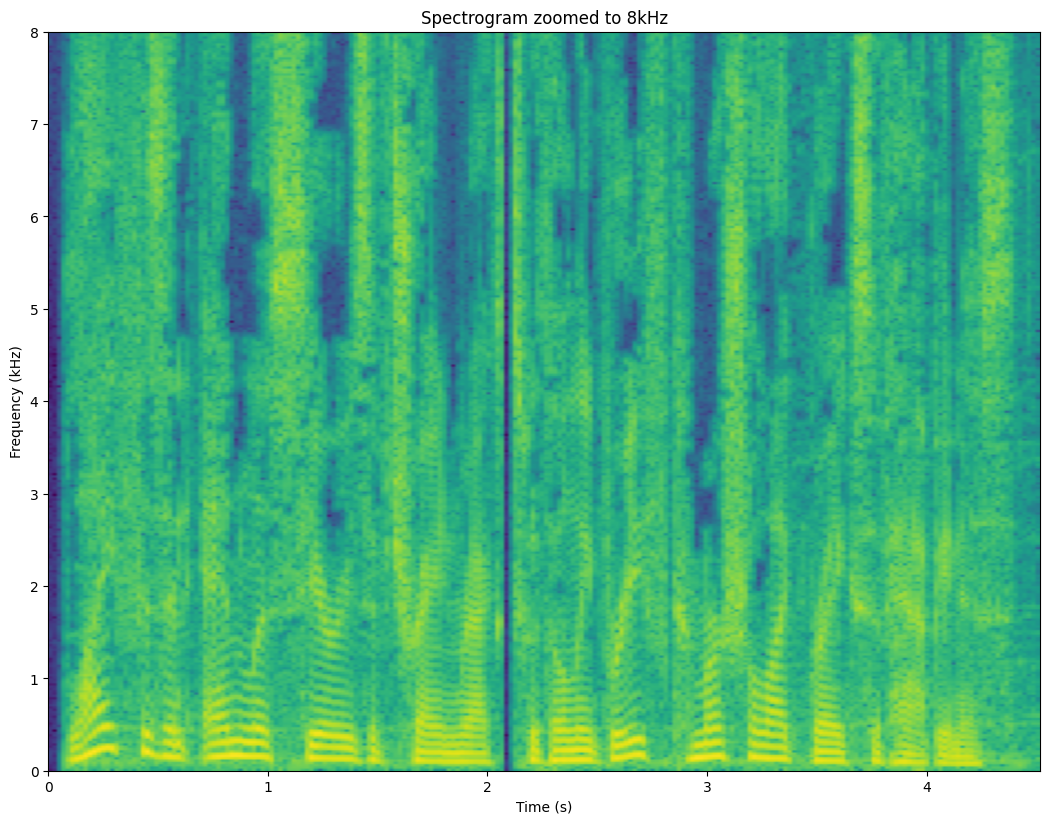

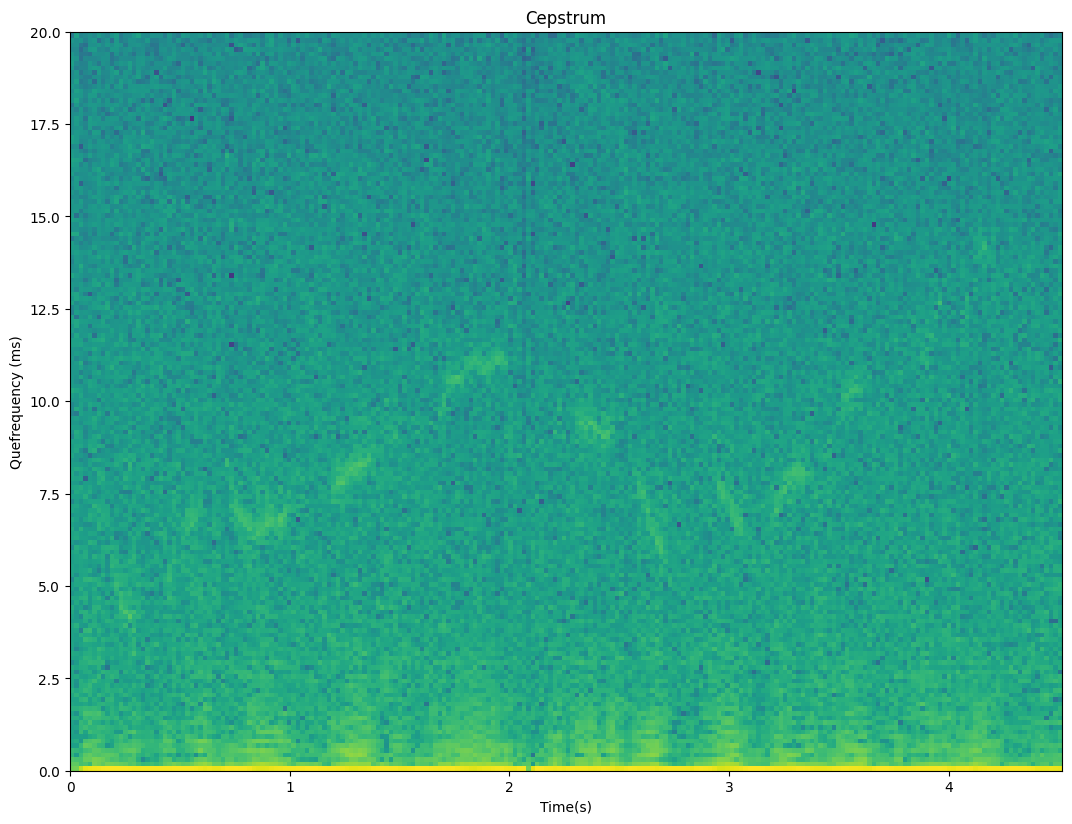

In [20]:
window_step_ms = 20
window_step = int(window_step_ms * fs / 1000)

spectrogram = helper_functions.stft(mono_signal, fs, window_length_ms=window_length_ms, window_step_ms=window_step_ms)
window_count = spectrogram.shape[0]

cepstrogram = np.zeros((len(cepstrum), window_count))

for k in range(window_count):
    starting_position = k * window_step
    data_vector = mono_signal[starting_position: (starting_position+window_length),]
    window = data_vector*windowing_fn
    time_vector = np.linspace(0, window_length_ms, window_length)

    spectrum = fft.rfft(window, n=spectrum_length)
    frequency_vector = np.linspace(0, fs/2000, len(spectrum))

    # downsample to 16kHz (that is, Nyquist frequency is 8kHz, that is, everything about 8kHz can be removed)
    idx = np.nonzero(frequency_vector <= 8)
    frequency_vector = frequency_vector[idx]
    spectrum = spectrum[idx]

    logspectrum = 20*np.log10(np.abs(spectrum))
    cepstrum = fft.rfft(logspectrum)
    cepstrogram[:, k] = np.abs(cepstrum)
    # cepstrogram[:, k] = np.abs(fft.rfft(20*np.log10(np.abs(spectrogram[k, idx])), axis=1))
    # cepstrogram = np.abs(scipy.fft.rfft(20*np.log10(np.abs(spectrogram[:,idx])),axis=1))

# minimum value for the log-value in the spectrogram - helps making the background really black
black_eps = 1e-1 
default_figsize = mpl.rcParamsDefault["figure.figsize"]
mpl.rcParams["figure.figsize"] = [val*2 for val in default_figsize]

mpl.rcParams["figure.figsize"] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps), 
                        aspect="auto", 
                        origin="lower", 
                        extent=[0, len(mono_signal)/fs, 0, fs/2000])

plt.xlabel("Time (s)")
plt.ylabel("Frequency (kHz)")
plt.axis([0, len(mono_signal)/fs, 0, 8])
plt.title("Spectrogram zoomed to 8kHz")
plt.show()

plt.imshow(np.log(np.abs(cepstrogram)+black_eps), 
                        aspect="auto", 
                        origin="lower", 
                        extent=[0, len(mono_signal)/fs, 0, ctime[-1]])
# plt.imshow(np.log(np.abs(cepstrogram)+black_eps),
#                         aspect='auto',
#                         origin='lower')
plt.title("Cepstrum")
plt.xlabel("Time(s)")
plt.ylabel("Quefrequency (ms)")
plt.axis([0, len(mono_signal)/fs, 0, 20])
plt.show()

## Downsampling

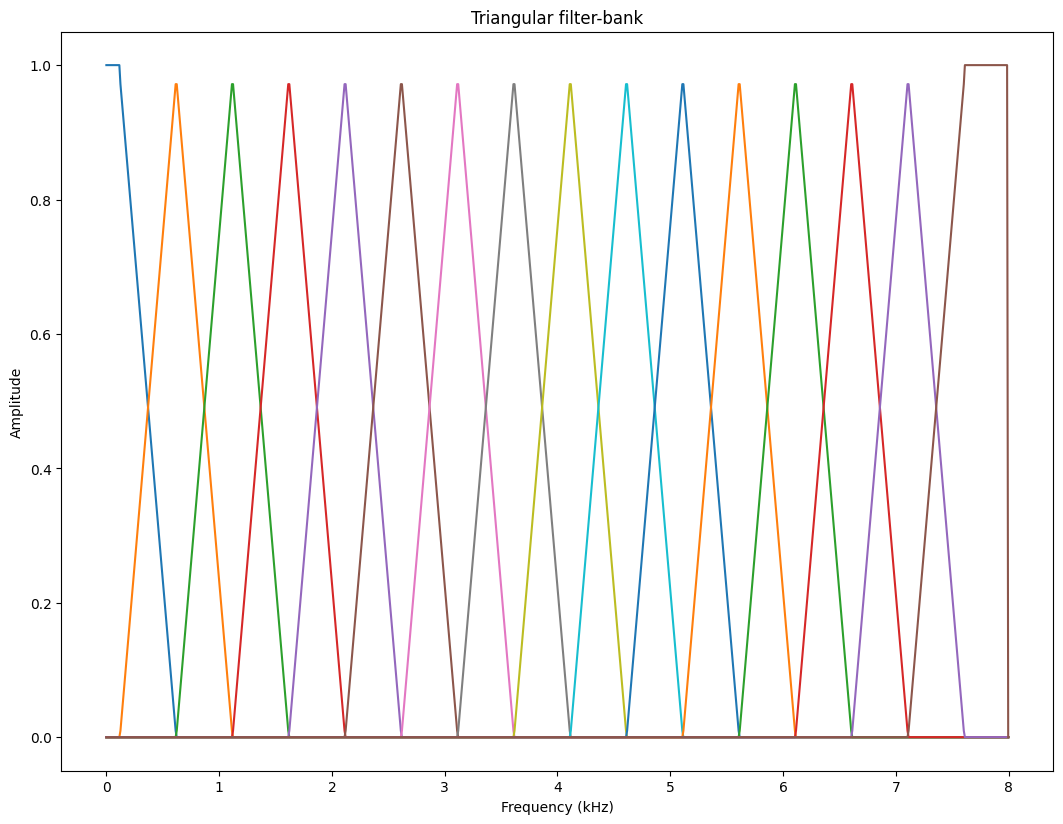

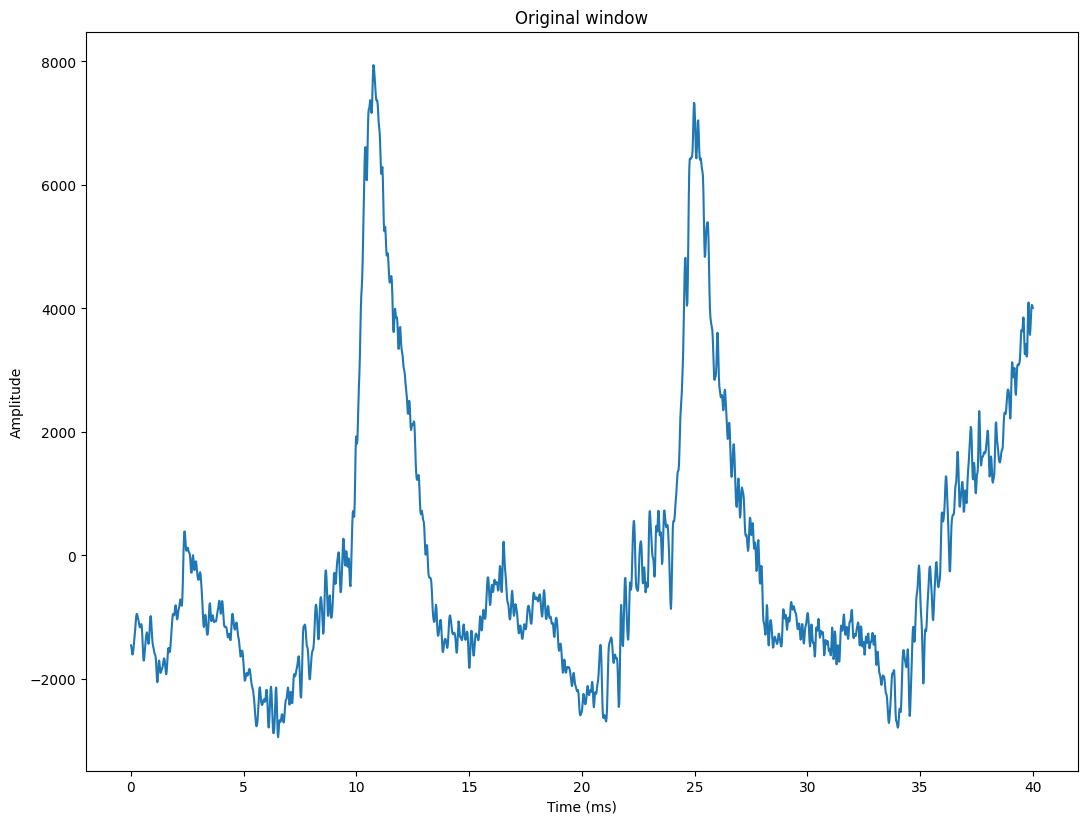

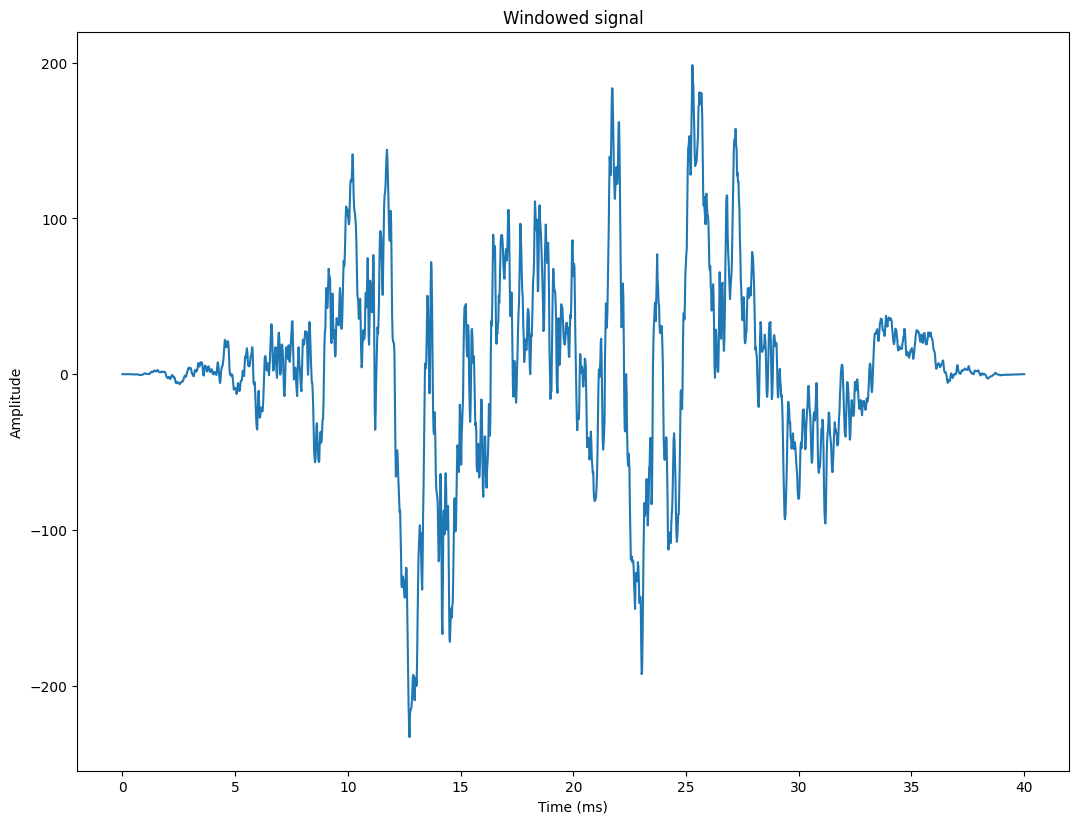

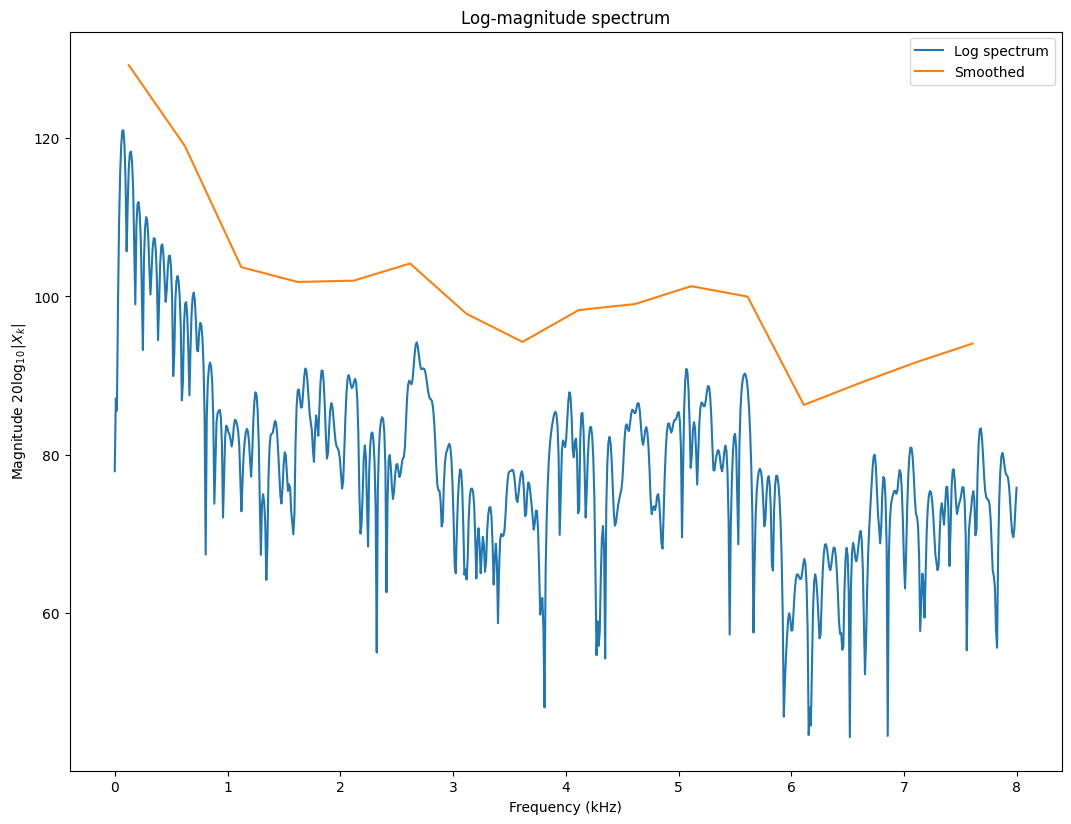

In [21]:
# choose segment from random position in sample
starting_position = np.random.randint(total_length - window_length)

data_vector = mono_signal[starting_position:(starting_position+window_length),]
window_signal = data_vector*windowing_fn
time_vector = np.linspace(0,window_length_ms,window_length)

spectrum = scipy.fft.rfft(window_signal,n=spectrum_length)
frequency_vector = np.linspace(0,fs/2000,len(spectrum))

# downsample to 16kHz (that is, Nyquist frequency is 8kHz, that is, everything about 8kHz can be removed)
idx = np.nonzero(frequency_vector <= 8)
frequency_vector = frequency_vector[idx]
spectrum = spectrum[idx]

log_spectrum = 20*np.log10(np.abs(spectrum))


# filterbank
frequency_step_Hz = 500
frequency_step = int(len(spectrum)*frequency_step_Hz/8000)
frequency_bins = int(len(spectrum)/frequency_step+0.5)

slope = np.arange(0.5,frequency_step+0.5,1)/(frequency_step+1)
backslope = np.flipud(slope)
filterbank = np.zeros((len(spectrum),frequency_bins))
filterbank[0:frequency_step,0] = 1
filterbank[(-frequency_step):-1,-1] = 1
for k in range(frequency_bins-1):
    idx = int((k+0.25)*frequency_step) + np.arange(0,frequency_step)
    filterbank[idx,k+1] = slope
    filterbank[idx,k] = backslope
    
# smoothing and downsampling
spectrum_smoothed = np.matmul(np.transpose(filterbank),np.abs(spectrum)**2)
log_spectrum_smoothed = 10*np.log10(spectrum_smoothed)
frequency_vector_tight = (np.arange(0,frequency_bins,1)+0.25)*frequency_step*8/len(spectrum)

plt.plot(frequency_vector, filterbank)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Amplitude")
plt.title('Triangular filter-bank')
plt.show()

plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

plt.plot(time_vector,window)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

plt.plot(frequency_vector,log_spectrum,label='Log spectrum')
plt.plot(frequency_vector_tight, log_spectrum_smoothed,label='Smoothed')
plt.legend()
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\\log_{10}|X_k|$')
plt.show()

## MEL SCALE

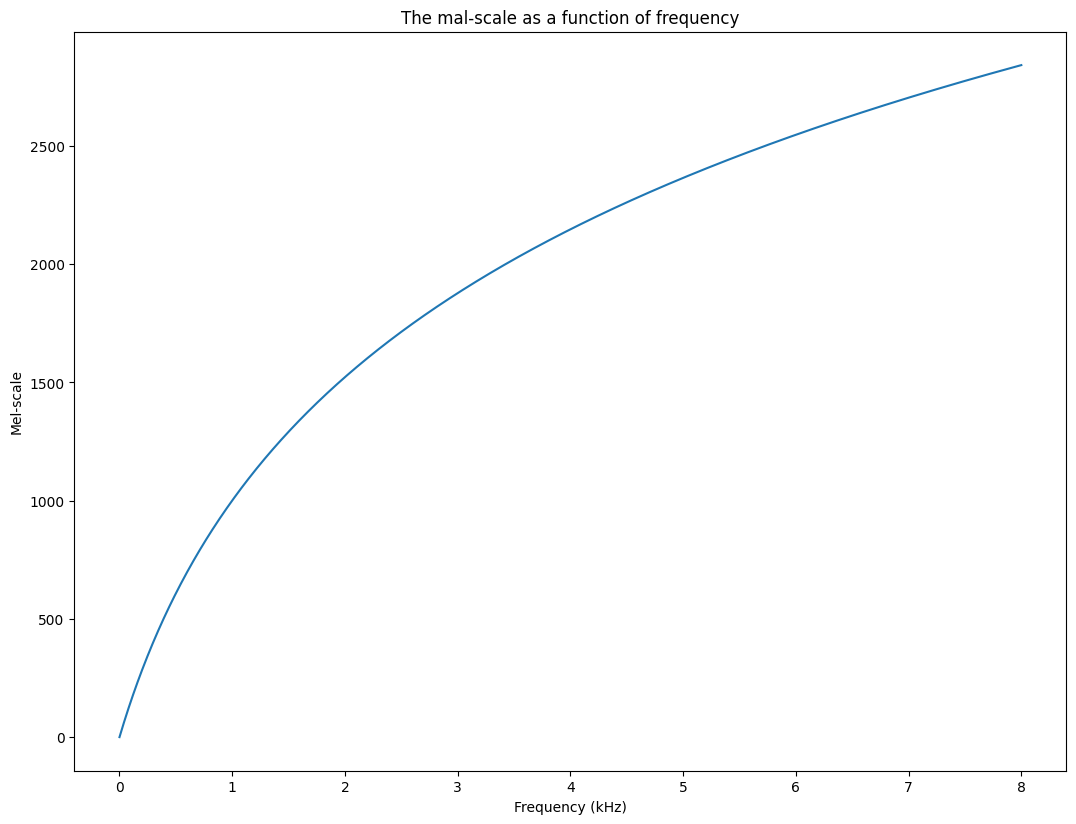

In [22]:
from helper_functions import freq2mel, mel2freq

f = np.linspace(0, 8000, 1000)
plt.plot(f/1000, freq2mel(f))
plt.xlabel("Frequency (kHz)")
plt.ylabel("Mel-scale")
plt.title("The mal-scale as a function of frequency")
plt.show()

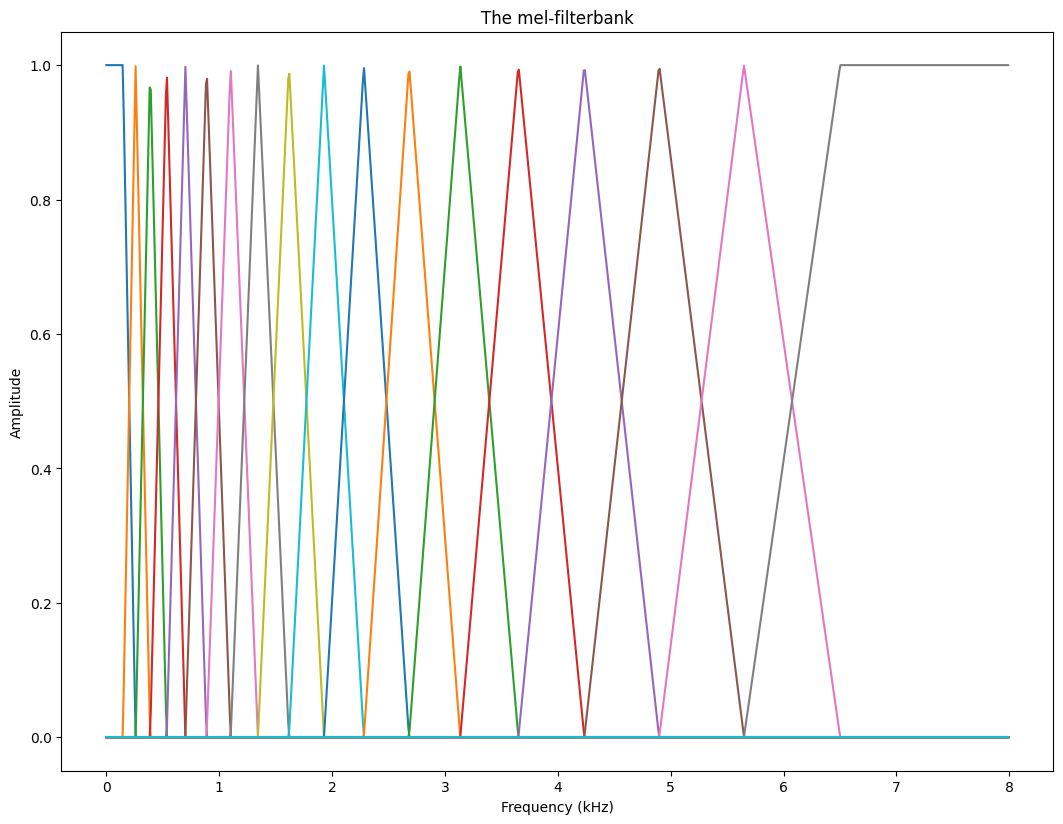

In [23]:
melbands = 20
maxmel = freq2mel(8000)
mel_idx = np.array(np.arange(0.5, melbands, 1)/melbands)*maxmel
freq_idx = mel2freq(mel_idx)

melfilterbank = np.zeros((len(spectrum), melbands))
freq_vec = np.arange(0, len(spectrum), 1)*8000/len(spectrum)
for k in range(melbands-2):
    if k > 0:
        upslope = (freq_vec - freq_idx[k])/(freq_idx[k+1] - freq_idx[k])
    else:
        upslope = 1 + 0*freq_vec
    if k < melbands-3:
        downslope = 1 - (freq_vec - freq_idx[k+1])/(freq_idx[k+2] - freq_idx[k+1])
    else:
        downslope = 1 + 0*freq_vec
    triangle = np.max([0*freq_vec, np.min([upslope, downslope], axis=0)], axis=0)
    melfilterbank[:, k] = triangle

melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2 + 1e-12, axis=0)**-1), np.transpose(melfilterbank))

plt.plot(freq_vec/1000, melfilterbank)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Amplitude")
plt.title("The mel-filterbank")
plt.show()

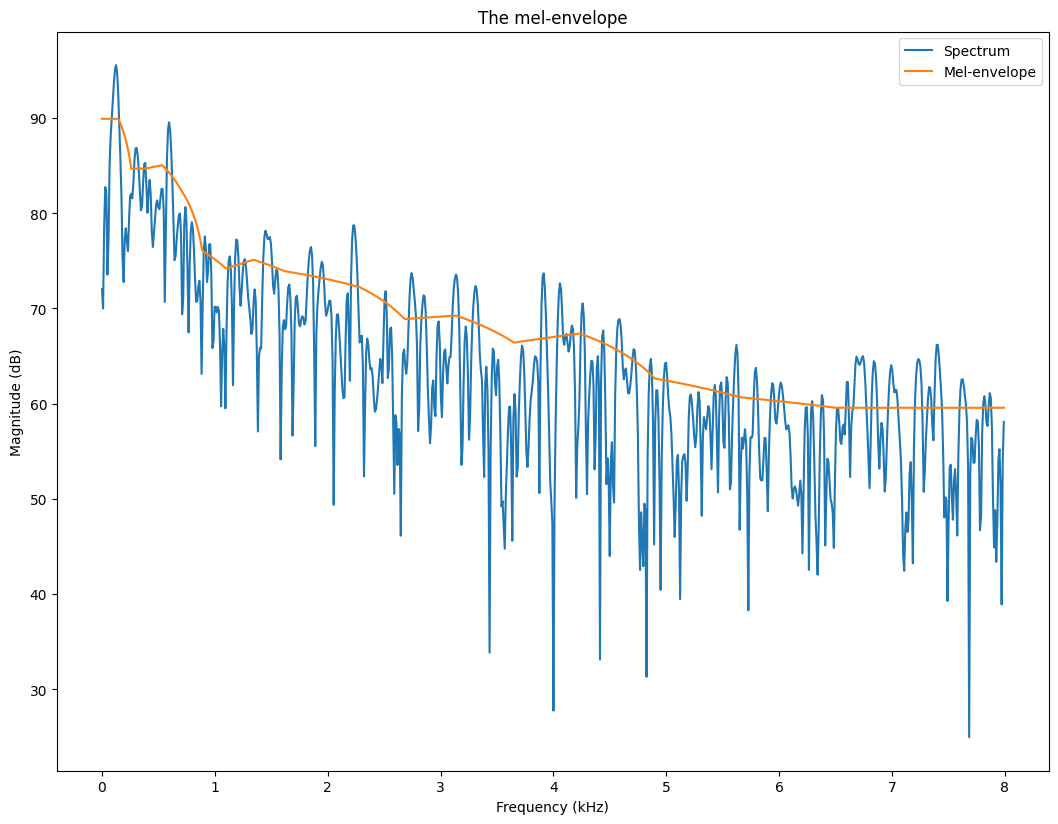

In [24]:
# Choose segment from random position in sample
starting_position = np.random.randint(0, len(mono_signal) - window_length)

data_vector = mono_signal[starting_position:(starting_position + window_length),]
window = data_vector*windowing_fn
time_vector = np.linspace(0, window_length_ms, window_length)

spectrum = fft.rfft(window, n=spectrum_length)
frequency_vector = np.linspace(0, fs/2000, len(spectrum))

# Downsample to 16kHz (that is, nyquist frequency is 8kHz, that is everything about 8kHz can be removed)
idx = np.nonzero(frequency_vector <= 8)
frequency_vector = frequency_vector[idx]
spectrum = spectrum[idx]
log_spectrum = 20*np.log10(np.abs(spectrum))

log_mel_spectrum = 10*np.log10(np.matmul(np.transpose(melfilterbank), np.abs(spectrum)**2)+1e-12)
log_envelope_spectrum = 10*np.log10(np.matmul(np.transpose(melreconstruct), 10**(log_mel_spectrum/10)))

plt.plot(freq_vec/1000,log_spectrum,label='Spectrum')
plt.plot(freq_vec/1000,log_envelope_spectrum,label='Mel-envelope')
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('The mel-envelope')
plt.show()

## The Mel-Frequency Cepstral Coefficients (MFCCs)

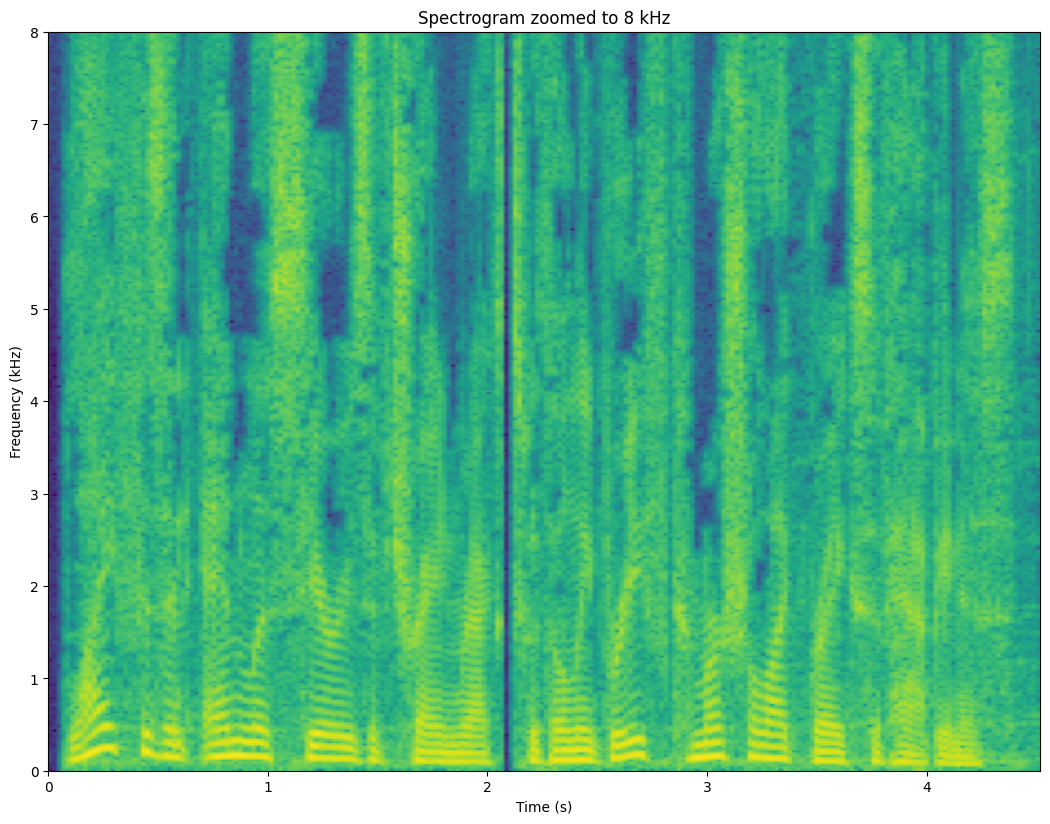

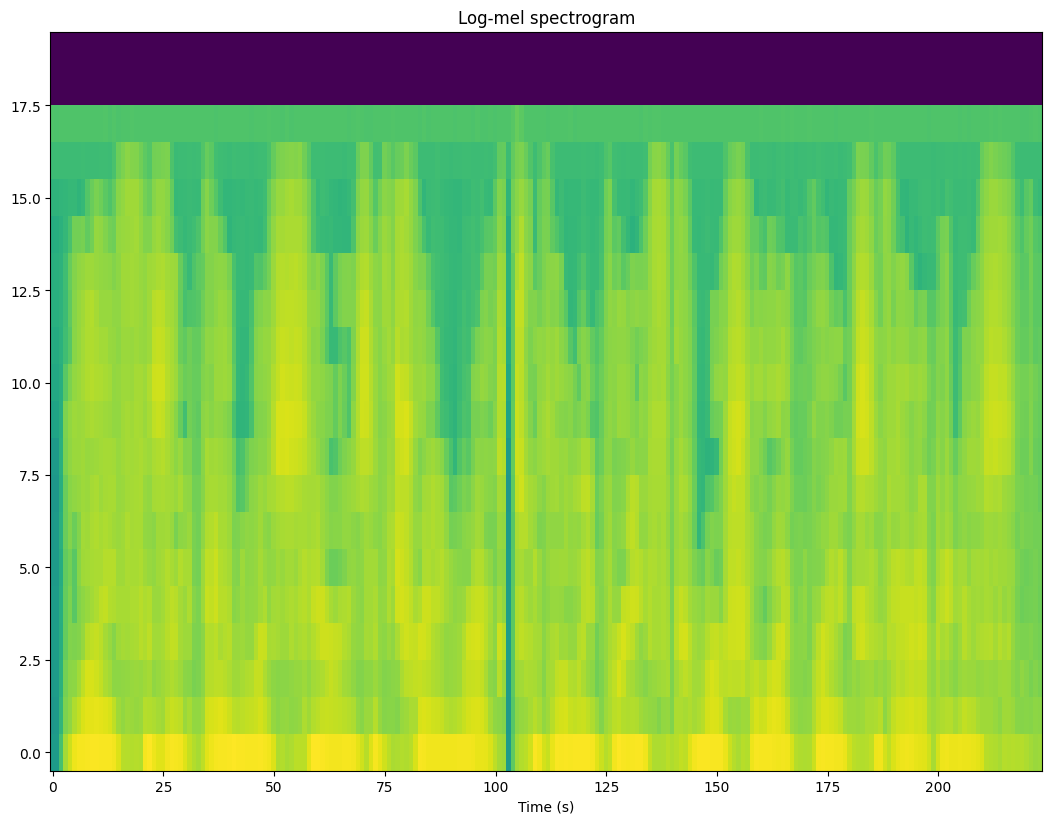

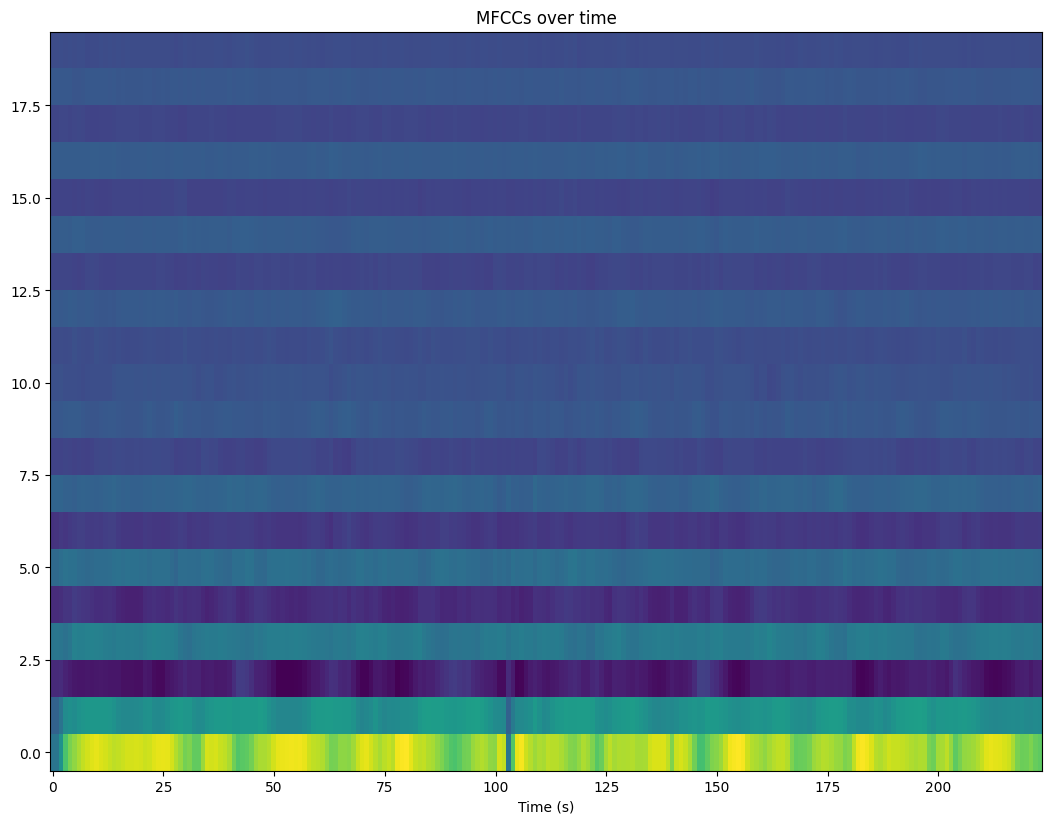

In [28]:
melbands = 20
maxmel = freq2mel(8000)
mel_idx = np.array(np.arange(.5,melbands,1)/melbands)*maxmel
freq_idx = mel2freq(mel_idx)

melfilterbank = np.zeros((spectrogram.shape[1],melbands))
freqvec = np.arange(0,spectrogram.shape[1],1)*8000/spectrogram.shape[1]
for k in range(melbands-2):    
    if k>0:
        upslope = (freqvec-freq_idx[k])/(freq_idx[k+1]-freq_idx[k])
    else:
        upslope = 1 + 0*freqvec
    if k<melbands-3:
        downslope = 1 - (freqvec-freq_idx[k+1])/(freq_idx[k+2]-freq_idx[k+1])
    else:
        downslope = 1 + 0*freqvec
    triangle = np.max([0*freqvec,np.min([upslope,downslope],axis=0)],axis=0)
    melfilterbank[:,k] = triangle
    
melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2+1e-12,axis=0)**-1),np.transpose(melfilterbank))


logmelspectrogram = 10*np.log10(np.matmul(np.abs(spectrogram)**2,melfilterbank)+1e-12)

mfcc = scipy.fft.dct(logmelspectrogram)


default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]

mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps),aspect='auto',origin='lower',extent=[0, len(mono_signal)/fs,0, fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.axis([0, len(mono_signal)/fs, 0, 8])
plt.title('Spectrogram zoomed to 8 kHz')
plt.show()


plt.imshow(np.transpose(logmelspectrogram),aspect='auto',origin='lower')
plt.xlabel('Time (s)')
#plt.ylabel('Quefrency (ms)')
#plt.axis([0, len(data)/fs, 0, 20])
plt.title('Log-mel spectrogram')
plt.show()


plt.imshow(np.transpose(mfcc),aspect='auto',origin='lower')
plt.xlabel('Time (s)')
#plt.ylabel('Quefrency (ms)')
#plt.axis([0, len(data)/fs, 0, 20])
plt.title('MFCCs over time')
plt.show()